<div style="text-align: right">INFO 6105 Data Sci Engineering Methods and Tools, Week 4 Lecture 2</div>
<div style="text-align: right">Dino Konstantopoulos, 1 October 2020, with material from Cam Davidson-Pilon</div>

* * * 
*At the end of this lecture, you should a good understanding of probability distributions, how to estimate probabilities for different outcomes and sample spaces, how to use Bayes' theorem to answer typical interview questions involving probabilities, and start thinking about finding a job in high-stakes sports, such as Formula 1 racing.*

*For next week, you should also read and try to understand Chapter 6 of your textbook, Mathematics for Machine Learning*.

# Homework solution

 Determine the probability that the sum of a three-dice roll is prime:
 
<center>
<img src="ipynb.images/3-dice-roll.png" width="200" />
</center>

In [13]:
from fractions import Fraction
def p(event, space): 
    """The probability of an event, given a sample space of equiprobable outcomes.
    event can be either a set of outcomes, or a predicate (true for outcomes in the event)."""
    if is_predicate(event):
        event = such_that(event, space)
    return Fraction(len(event & space), len(space))

is_predicate = callable

def such_that(predicate, collection): 
    """The subset of elements in the collection for which the predicate is true."""
    return {e for e in collection if predicate(e)}

In [2]:
D = {1,2,3,4,5,6}

In [3]:
D3 = {(d1, d2, d3) for d1 in D for d2 in D for d3 in D}

In [4]:
def prime_sum(outcome): return is_prime(sum(outcome))

In [5]:
def is_prime(n): return n > 1 and not any(n % i == 0 for i in range(2, n)) #100 points if your python looks this simple

In [6]:
p(prime_sum, D3)

Fraction(73, 216)

# Introduction to Probability Distributions

Your textbook, in page 6, states that the foundations of Machine Learning are:

<center>
<img src="ipynb.images/foundations-of-ML.png" width="500" />
</center>

And so let's start with a lab that introduces a very important probability distribution: The **binomial**.

<br />
<center>
<img src="http://statistics.wdfiles.com/local--files/ch6/binomial.png" width="400" />
Binomial
</center>

>**Definition**: Tthe binomial distribution with parameters $n$ and $p$ is the discrete probability distribution of the number of successes in a sequence of $n$ *independent* experiments, each asking a yes–no question, and each with its own boolean-valued outcome: success/yes/true/one (with probability $p$) or failure/no/false/zero (with probability $q = 1 − p$). 

A single success/failure experiment is also called a **Bernoulli** trial or Bernoulli experiment and a sequence of outcomes is called a Bernoulli process; for a single trial, i.e., $n = 1$, the binomial distribution is a Bernoulli distribution.

Why is it important?

So far, we have made the assumption that every outcome in a sample space (such as our urn) is ***equally likely***: Same probability to select White ball \#1 as Red ball \#5. Right?

>**Recall**: A probability is a **fraction** where the numerator is sum of all *favorable* outcomes, and the denominator the sum of all *possible* outcomes.

In real life, we often get outcomes that are not **equiprobable**. For example, White ball versus Red ball in our previous experiment. For example, the probability that your professor marries Rihana is not as probably as the probability that some famous rock start marries Rihanna.

For another example, the probability of a child being a girl is not exactly 1/2, and the probability is slightly different for a second child. 

An [article](http://people.kzoo.edu/barth/math105/moreboys.pdf) (good Data Science article, please read it) gives the following *counts* for two-child families in Denmark, where `GB` means a family where the first child is a girl and the second a boy:

    GG: 121801    GB: 126840
    BG: 127123    BB: 135138
    
Because of this fact (not all urns yield Blue/Red/White *numbered* balls with equiprobable chances), we need to introduce three more definitions:

* [Frequency](https://en.wikipedia.org/wiki/Frequency_%28statistics%29): a number describing how often an outcome occurs. Can be a count like 121801, or a ratio like 0.515.

* [Distribution](http://mathworld.wolfram.com/StatisticalDistribution.html): A mapping from outcome to frequency for each possible outcome in a sample space. 

* [Probability Distribution](https://en.wikipedia.org/wiki/Probability_distribution): The distribution above, which has been *normalized* so that the sum of the frequencies is 1.

Here is an example of a ***super-popular*** probability distribution:
* The binomial distribution is frequently used to model the number of successes in a sample of size n drawn with replacement from a population of size N.

Oh noooooo...
<center>
    <img src="ipynb.images/miserable.png" width=300 />
</center>

We need to again modify our awesome probability counting `p()` function (which takes each event as **equiprobable**) to take this miserable fact into account. Essentially, it's as if each *numbered ball* comes with its *own* probability of being picked. So we will need to use probability **dictionaries**.

We love python dictionaries, right, so it should be fun, right?

<br />
<center>
    <img src="ipynb.images/pin.gif" width=400 />
</center>

First, let's plot a few binomial distributions:

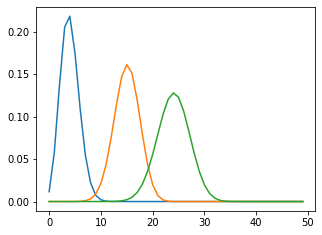

In [7]:
# n and p are exactly as defined above
import numpy as np
from scipy.stats import binom
from matplotlib import pyplot as plt
%matplotlib inline

n_values = [20, 25, 40]
p_values = [0.2, 0.6, 0.6]
x = np.arange(0, 50)

fig, ax = plt.subplots(figsize=(5, 3.75))

for (n, p) in zip(n_values, p_values):
    # create a binomial distribution
    dist = binom(n, p)

    plt.plot(x, dist.pmf(x))

Now, let's digress a bit into abstract computer science..

In Python, `*args` and `**kwargs` is a common idiom to allow ***arbitrary number of arguments*** to functions. `*args` will give you all function parameters as a tuple, `**kwargs` will give you all keyword arguments (except those corresponding to a formal parameter) as a dictionary:
```python
def foo(*args):
    for a in args:
    print a
        
def bar(**kwargs):
    for a in kwargs:
        print a, kwargs[a]
```

Let’s say we want to create a higher-order function that takes as input some function $f$ and returns a new function that for any input returns *twice* the value of $f$:

In [8]:
def my_doubler(f):
  def my_g(x):
    return 2 * f(x)
  return my_g

It works.. in most cases:

In [9]:
def f_plus_1(x):
  return x + 1;

h = my_doubler(f_plus_1)
print(h(3))  # 8 = (3 + 1) * 2

8


Now try this:

In [10]:
def my_sum2(x, y):
  return x + y;

h = my_doubler(my_sum2)
print(h(1,2)) #TypeError!

TypeError: my_g() takes 1 positional argument but 2 were given

Oh *nooooo*!

What we need is a way to specify a function that takes *arbitrary arguments*. This is where Python's `*args` and `**kwargs` come into play:

In [22]:
def magic(*args, **kwargs):
  print ("unnamed args: ", args)
  print ("keyword args: ", kwargs)
magic(1, 2, 3, key1 = 'NU', key2 = 'rocks!')

unnamed args:  (1, 2, 3)
keyword args:  {'key1': 'NU', 'key2': 'rocks!'}


<br />
<center>
    <img src="ipynb.images/magic.png" width=300 />**Ohhhhhhhhhhhh**</a><br>你真聪明
</center>

args is a `tuple` of its unnamed arguments and kwargs is a `dictionary` of its named arguments. So now we can:

In [11]:
def my_new_doubler(f):
  """works no matter the inputs"""
  def my_g(*args, **kwargs):
    """pass all arguments to f"""
    return 2 * f(*args, **kwargs)
  return my_g

and now:

In [13]:
h = my_new_doubler(my_sum2)
print(h(1, 2))  # 6:

6


Ok, ***now*** are ready to define **Probability distributions** in python, our new *p* function!

We define `ProbDist` to take the same kinds of arguments that a `dict` does: either a **mapping** (from item to its probability) or a **set** of (key, val) pairs, and/or optional keyword arguments (because each ball in the urn is *special* now: it has its *own* probability of being picked). 

>**A dose of reality**: It's like all boys/girls are not equal! You will not just pick any boy/girl to be your girl/boyfriend! There are some that have a *much higher chance* of being picked by you (related to *your* taste)!

This is the first time (in class), that we will define a Python `class`, instead of a Python **function/lambda**. That is why we will define its **constructor** `__init__()`. We assume `self` (`this` in Python) is composed of a set:

In [6]:
class ProbDist(dict):
    """A Probability Distribution; an {outcome: probability} mapping."""
    def __init__(self, mapping=(), **kwargs):
        self.update(mapping, **kwargs)
        # Make probabilities sum to 1.0; assert no negative probabilities
        total = sum(self.values())
        for outcome in self:
            self[outcome] = self[outcome] / total
            assert self[outcome] >= 0

We also need to modify the functions `p` and `such_that` to accept either a sample space as we had previously, or a probability distribution as the second argument `space`. 

>**Oh-oh**: Now we need to branch out on the ***2nd argument*** of function `p`!

If we have a probability distribution, instead of *counting* each possible outcome equiprobably and thus just summing up `1`s (numerator: sum of all *favorable* outcomes, denominator: sum of all *possible* outcomes), we need to sum up the different discrete probabilities of each possible outcome: `sum(space[o] for o in space if o in event)`. 

We also need to modify `such_that()`, which is the set of all outcomes of our sample space for which the predicate (first) argument is `True`, so that its second argument can also be a `ProbDist`.

In [7]:
def p(event, space): 
    """The probability of an event, given a sample space of equiprobable outcomes. 
    event: a collection of outcomes, or a predicate that is true of outcomes in the event. 
    space: a set of outcomes or a probability distribution of {outcome: frequency} pairs."""
    # branch on the type of the first argument
    if is_predicate(event):
        # transform the mapping (untangible) 'event' into the collection (tangible) 'event'
        event = such_that(event, space)
        
    # branch on the type of the second argument
    if isinstance(space, ProbDist):
        # if space is a dictionary of distinct probabilities, each element does not count as the same amount:
        # We need to be careful and count each amount according to what it's worth
        return sum(space[o] for o in space if o in event)
    else:
        # space is not a dictionary, let's fall back to our original division
        return Fraction(len(event & space), len(space))

is_predicate = callable

def such_that(predicate, space): 
    """The outcomes in the sample pace for which the predicate is true.
    If space is a set, return a subset {outcome,...} with outcomes where predicate(element) is true;
    if space is a ProbDist, return a ProbDist {outcome: frequency,...} with outcomes where predicate(element) is true."""
    if isinstance(space, ProbDist):
        return ProbDist({o:space[o] for o in space if predicate(o)})
    else:
        return {o for o in space if predicate(o)}

And now we can finally take on the Danes from the data science paper!
<br />
<center>
    <img src="ipynb.images/Danes.png" width=300 />
</center>

# Danish two-child families: An introduction to *conditional* and *marginal* probabilities
Here is the probability distribution for Danish two-child families as a `dictionar`y, describing the probability of each possible outcome, according to the data science paper referenced above:

In [19]:
DK = ProbDist(GG=121801, GB=126840,
              BG=127123, BB=135138)
DK

{'GG': 0.23840384261560926,
 'GB': 0.24826679089140383,
 'BG': 0.24882071317004043,
 'BB': 0.2645086533229465}

Let's write some useful predicates (in lambda syntax):
```python
def first_girl(outcome):  return outcome[0] == 'G'
def first_boy(outcome):   return outcome[0] == 'B'
def second_girl(outcome): return outcome[1] == 'G'
def second_boy(outcome):  return outcome[1] == 'B'
def two_girls(outcome):   return outcome    == 'GG'
```
Using these predicates, answer the following questions:

* What's the probability for a girl, and is it higher or lower for a second girl?
* Is the sex of the second child more likely or less likely to be the same as the first child?

*Hint:* You will leverage `p(first_girl, DK)`, `p(second_girl, DK)`, `p(second_girl, such_that(first_girl, DK))`, and `p(second_girl, such_that(first_boy, DK))`

In [20]:
def first_girl(outcome):  return outcome[0] == 'G'
def first_boy(outcome):   return outcome[0] == 'B'
def second_girl(outcome): return outcome[1] == 'G'
def second_boy(outcome):  return outcome[1] == 'B'
def two_girls(outcome):   return outcome    == 'GG'

In [21]:
p(first_girl, DK)

0.4866706335070131

In [20]:
p(second_girl, DK)

0.4872245557856497

The above says that the probability of a girl is somewhere between 48% and 49%, but that it is slightly different between the first or second child.

Now answer the question as to whether the sex of the second child is *more likely* or *less likely* to be the same as the first child, by evaluating first:

- The probability of a second girl *given that the first child was a girl* (a [conditional probability](https://en.wikipedia.org/wiki/Conditional_probability))
- The probability of a second girl *given that the first child was a boy* (a conditional probability)
- The probability of a second boy *given that the first child was a boy* (a conditional probability)
- The probability of a second boy *given that the first child was a girl* (a conditional probability)

The average of the ***first*** two probabilities above represents the probability of a second girl (*irrespective* of any other conditions)! It's a [marginal probability](https://en.wikipedia.org/wiki/Marginal_distribution) in our problem.

The average of the ***last*** two probabilities above represents the probability of a second boy, a **marginal probability** in our problem.

These are the first two conditional probabilities:

In [22]:
p(second_girl, such_that(first_girl, DK)), p(second_girl, such_that(first_boy, DK))

(0.4898669165584115, 0.48471942072973107)

In [23]:
p(second_girl, such_that(second_girl, DK))

1.0

These are the last two conditional probabilities:

In [22]:
p(second_boy, such_that(first_girl, DK)), p(second_boy, such_that(first_boy, DK))

(0.5101330834415885, 0.5152805792702689)

The above says that the sex of the second child is more likely to be the same as the first child, by about 1/2 a percentage point.

And so, the result we are after:

In [23]:
p_second_girl = (p(second_girl, such_that(first_girl, DK)) + p(second_girl, such_that(first_boy, DK)))/2.
p_second_girl

0.4872931686440713

In [25]:
p_second_boy = (p(second_boy, such_that(first_girl, DK)) + p(second_boy, such_that(first_boy, DK))) / 2.
p_second_boy

0.5127068313559286

You should find that the probability of a girl is somewhere between 48% and 49%, but slightly different between the first or second child, and that the sex of the second child is more likely to be the same as the first child, by about 1/2 a percentage point.

Cooool..! We got all that through *programming*. No math! By spelling out our sets and writing down our logic.

<br />
<center>
<img src="ipynb.images/pretty-bunny.gif" />
</center>

# 6. M&Ms and an introduction to Bayes' Theorem
<br />
<center>
<img src="https://upload.wikimedia.org/wikipedia/en/9/97/M%26M_spokescandies.jpeg" />
</center>

[Bayes's theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem) describes the probability of an event $A$, based on prior knowledge of conditions $E$ that might be related to the event:

$$P(A \;|\; E) = \frac{P(E \;|\; A) \;*\; P(A)}{ P(E) }$$

Just like the `1 minus` trick for estimatiung probabilities, you use Bayes' theorem when $P(E \;|\; A)$ is easier to compute than $P(A \;|\; E)$.

For example, if the risk of developing deadly covid19 problems is known to increase with age and medical preconditions. Bayes's theorem allows the risk to an individual of a known age or having a medical precondition to be assessed more accurately than simply assuming that the individual is typical of the population as a whole.

Let's study Bayes with another experiment.

Here's another urn problem (or "bag" problem) [from](http://allendowney.blogspot.com/2011/10/my-favorite-bayess-theorem-problems.html) prolific Python/Probability author [Allen Downey ](http://allendowney.blogspot.com/), which also happens to be a classic interview question:

> The blue M&M was introduced in 1995.  Before then, the color mix in a bag of plain M&Ms was (30% Brown, 20% Yellow, 20% Red, 10% Green, 10% Orange, 10% Tan).  Afterward it was (24% Blue , 20% Green, 16% Orange, 14% Yellow, 13% Red, 13% Brown). 
A friend of mine has two bags of M&Ms, and he tells me that one is from 1994 and one from 1996.  He won't tell me which is which, but he gives me one M&M from each bag.  One is yellow and one is green.  What is the probability that the yellow M&M came from the 1994 bag? Well, the old M&M bags' yellow count was higher, so it must be higher, right? But how to count?

To solve this problem, we'll first represent probability distributions for each bag: `bag94` and `bag96`, by using `ProbDist` and passing in dictionaries for each year:
```python
bag94 = ProbDist(brown=30, yellow=20, red=20, green=10, orange=10, tan=10)
bag96 = ProbDist(...)  #fill this in, please
```

In [35]:
bag94 = ProbDist(brown=30, yellow=20, red=20, green=10, orange=10, tan=10)
bag96 = ProbDist(blue=24, green=20, orange=16, yellow=14, red=13, brown=13)

Next, define `MM` as the *joint* distribution 94-96&mdash;the sample space for picking *one* M&M from *each* bag. The outcome `'yellow green'` means that a yellow M&M was selected from the 1994 bag and a green one from the 1996 bag. We will use a *set comprehension*.

Uhhhh... What do we use for sets again? Is it `[`, or `(`, or `{`?

To note:
* We are using a python *set* because we care about dictionaries, and dictionary keys are unique
* You can also think in terms of JSON objects

```python
def joint(A, B, sep=''):
    """The joint distribution of two independent probability distributions. 
    Result is all entries of the form {a+sep+b: P(a)*P(b)}"""
    return ProbDist({a + sep + b: A[a] * B[b]
                    for ...
                    for ...})

MM = joint(bag94, bag96, ' ')
MM
```

In [36]:
def joint(A, B, sep=''):
    """The joint distribution of two independent probability distributions. 
    Result is all entries of the form {a+sep+b: P(a)*P(b)}"""
    return ProbDist({a + sep + b: A[a] * B[b]
                    for a in A
                    for b in B})

MM = joint(bag94, bag96, ' ')
MM

{'brown blue': 0.07199999999999997,
 'brown brown': 0.038999999999999986,
 'brown green': 0.05999999999999997,
 'brown orange': 0.04799999999999998,
 'brown red': 0.038999999999999986,
 'brown yellow': 0.04199999999999998,
 'green blue': 0.02399999999999999,
 'green brown': 0.012999999999999996,
 'green green': 0.019999999999999993,
 'green orange': 0.015999999999999993,
 'green red': 0.012999999999999996,
 'green yellow': 0.013999999999999995,
 'orange blue': 0.02399999999999999,
 'orange brown': 0.012999999999999996,
 'orange green': 0.019999999999999993,
 'orange orange': 0.015999999999999993,
 'orange red': 0.012999999999999996,
 'orange yellow': 0.013999999999999995,
 'red blue': 0.04799999999999998,
 'red brown': 0.025999999999999992,
 'red green': 0.03999999999999999,
 'red orange': 0.03199999999999999,
 'red red': 0.025999999999999992,
 'red yellow': 0.02799999999999999,
 'tan blue': 0.02399999999999999,
 'tan brown': 0.012999999999999996,
 'tan green': 0.019999999999999993,
 '

Let's look at the "One is yellow and one is green" part:

```python
def yellow_and_green(outcome): return 'yellow' in outcome and 'green' in outcome

such_that(...) # fill this in
```

In [38]:
def yellow_and_green(outcome): return 'yellow' in outcome and 'green' in outcome
such_that(yellow_and_green, MM)

{'green yellow': 0.25925925925925924, 'yellow green': 0.7407407407407408}

Now we can answer the question: given that we got a yellow and a green (but don't know which comes from which bag), what is the probability that the yellow came from the 1994 bag?

```python
def yellow94(outcome): return ...

p(yellow94, such_that(...)) # fill this in
```

In [39]:
def yellow94(outcome): return outcome.startswith('yellow')

p(yellow94, such_that(yellow_and_green, MM))

0.7407407407407408

So there is a 74% chance that the yellow comes from the 1994 bag. We were *right* about our hunch :-)

Answering this question was straightforward: just like all the other probability problems, we simply create a sample space, and use `p` to pick out the probability of the event in question, given what we know about the outcome. This is the 'mechanistic' way of obtaining our answer.

# With Math
We can *also* solve it using *Bayes' Theorem*, and this is as good as any's introduction to naive Bayes theory: We are asked about the probability of an event (M&M94 --> M&M96) given the evidence (M&M94 is yellow, M&M96 green), which is not immediately available. However the probability of the evidence, given the event is readily available!  

Before we see the colors of the M&Ms, there are two hypotheses, `A` and `B`, both with equal probability:

    A: first M&M from 94 bag, second from 96 bag
    B: first M&M from 96 bag, second from 94 bag
    P(A) = P(B) = 0.5
    
Then we get some evidence:
    
    E: first M&M yellow, second green
    
We want to know the probability of hypothesis `A`, given the evidence:
    
    P(A | E)
    
That's not easy to calculate (except by enumerating the sample space, which is what we did above). But Bayes Theorem says:
    
    P(A | E) = P(E | A) * P(A) / P(E)
    
The quantities on the *right-hand-side* are easier to calculate:
    
    P(E | A) = 20/100 * 20/100 = 0.04
    P(E | B) = 10/100 * 14/100 = 0.014
    P(A)     = 0.5
    P(B)     = 0.5
    P(E)     = P(E | A) * P(A) + P(E | B) * P(B) 
             = 0.04     * 0.5  + 0.014    * 0.5   =   0.027
             
Where did the probability of the evidence P(E) formula come from?

There are two possibilities of getting the evidence: A and B, a *union* and so we sum their probabilities. The joint probability of the evidence *and* case A is a succession or *intersection*, so it must be a product of their probabilities: P(E|A).P(A). Likewise for the case B: P(E|B).P(B) 
    
And so we can get a final answer:
    
    P(A | E) = P(E | A) * P(A) / P(E) 
             = 0.04     * 0.5  / 0.027 
             = 0.7407407407
             
Bayes Theorem allows you to do less calculation at the cost of more algebra; that is a great trade-off if you are working with pencil and paper (like in interview situations). Enumerating the state space allows you to do less algebra at the cost of more calculation; often a good trade-off if you have a computer. But regardless of the approach you use, it is important to understand Bayes theorem and how it works.

Bayes' theorem will be our introduction to more advanced statistics, which we'll cover *next* week!

# Big Data? Big Deal..

So far, we have talked of an *outcome* as being a single state of the world. But it can be useful to break that state of the world down into *many* components. We call these components **random variables**. For example, when we consider an experiment in which we roll *two* dice and observe their sum, we could model the situation with *two* random variables, one for each die (our representation of outcomes has been doing that implicitly all along, when we concatenate two parts of a string, but the concept of a random variable makes it official.)

Remember [this](https://www.mathsisfun.com/data/quincunx.html) experiment?

The **Central Limit Theorem** states that if you have a collection of random variables and sum them up, then the *larger* the collection, the *closer* the sum will be to a *normal distribution* (also called a *Gaussian distribution* or a *bell-shaped curve*). This illustrates why Data Science with **Big Data** is not really a challenge at all (other than how to store and compute with data that is larger than the RAM on your laptop)! If you have tons of data, then frequentist and Bayesian statistics coincide, there is little doubt about outcomes, and it is clear which outcome to place your bets on.

The challenge is with **Small Data**, where there is doubt and you have no idea of the pdf, and you have to painstakingly  build a model with parameters, and refine your parameters so the model fits the data.

Why do accidents happen in autonomous vehicles when it snows, at dusk, when the moon is behind a traffic light, and a pedestrian is crossing the street on a red light? Precisely because we don't have Big Data about that use case, and the autonomous car has **no idea what to do**! Uber needs *you* to program it for the Small DAta cases. Big Data is piece of cake!

This is a good time to introduce the concept of a **histogram**, which is essentially a probability density function that we get from data collection or from analytic curves. If we have the 2D function `f(x,y)`, we can estimate the discretized probability density function (pdf) of `f` by computing how many values of `f` fall into specific bins with prespecified values of y.

Plot the pdf of the following graph:
<br />
<center>
    <img src="ipynb.images/graph.png" width=200 />
</center>

### Celtics

As another example, let's take 5 random variables reprsenting the per-game scores of the 5 Celtics starters for the 2018 season (Jayson Tatum or JT, Jaylen Brown or JB, Terry Rozier or TR, Al Horford or AL, and Aron Baynes or AB), and then sum them together to form the team score. The scores here are imaginary to introduce statistical function `gauss`, `triangular`, `vonmisesvariate`, and `uniform`. For the real season scores of this exciting and ultimately deflating season, visit [here](http://www.nba.com/celtics/stats?sort=PTS). Each random variable/player is represented as a probability distribution function; calling the function returns a single sample from the distribution:

In [2]:
from random import gauss, triangular, choice, vonmisesvariate, uniform

def JT(): return posint(gauss(15.1, 3) + 3 * triangular(1, 4, 13)) # 30.1
def JB(): return posint(gauss(10.2, 3) + 3 * triangular(1, 3.5, 9)) # 22.1
def TR(): return posint(vonmisesvariate(30, 2) * 3.08) # 14.0
def AH(): return posint(gauss(6.7, 1.5) if choice((True, False)) else gauss(16.7, 2.5)) # 11.7
def AB(): return posint(triangular(5, 17, 25) + uniform(0, 30) + gauss(6, 3)) # 37.0

def posint(x): "Positive integer"; return max(0, int(round(x)))

And here is a function to sample a random variable *k* times, show a histogram of the results, and return the mean:

In [3]:
from statistics import mean

def repeated_hist(rv, bins=10, k=100000):
    "Repeat rv() k times and make a histogram of the results."
    samples = [rv() for _ in range(k)]
    plt.hist(samples, bins=bins, color = 'g')
    return mean(samples)

The two top-scoring players, Jayson Tatum (JT) and Jaylen Brown (JB), have scoring distributions that are slightly skewed from normal:

30.08343

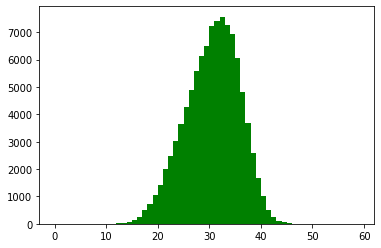

In [4]:
repeated_hist(JT, bins=range(60))

22.1383

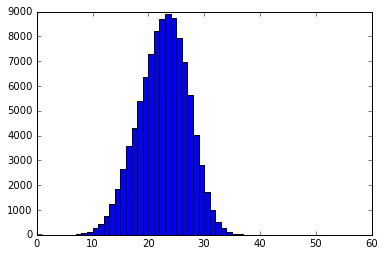

In [59]:
repeated_hist(JB, bins=range(60))

The next two players have bi-modal distributions; some games they score a lot, some games not:

14.02429

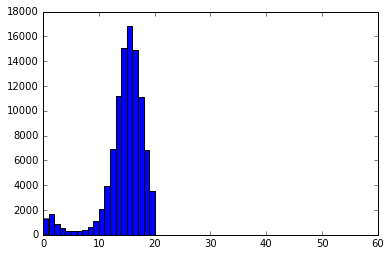

In [60]:
repeated_hist(TR, bins=range(60))

11.70888

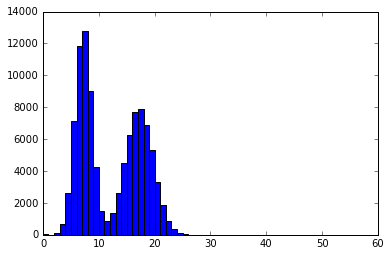

In [61]:
repeated_hist(AH, bins=range(60))

The fifth "player" (actually the sum of all the other players on the team, not really Aron Baymes, or they would have easily defeated the Cavaliers!) looks like this:

36.31564

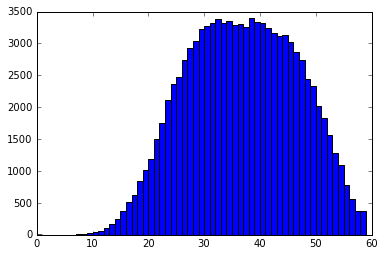

In [62]:
repeated_hist(AB, bins=range(60))

Go ahead, add more players to the Celtics, each with their own scoring distribution. Modify and use the below template:
```python
def XX(): return posint(gauss(15.1, 3) + 3 * triangular(1, 4, 13)) # 30.1
```

Add then in the cell below:

Now we define the team score to be the sum of the five players, and look at the distribution. Don't forge to add your own players!

114.23708

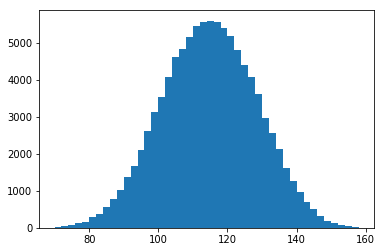

In [11]:
def GSW(): return JT() + JB() + TR() + AH() + AB()  # + ... add your own players!

repeated_hist(GSW, bins=range(70, 160, 2))

Sure enough, this looks very much like a **normal distribution**! 

The Central Limit Theorem holds, and that is why the statistics of NBA teams are so *predictable*. 

When you have a lot of data, you have little doubt, and the Data Science is *easy*. Deep Learning ANNs are very good at building hypersurfaces that match all the state variables of past outcomes. When you are asked to predict new outcomes based on a partial subset of state variables (independent variables), machines just project the lower dimensional hypersurface onto the higher dimensional hypersurface (stored in very compact form) and fill in the missing dimensions in order to predict the dependent variables. 

<br />
<center>
    <img src="ipynb.images/manifold.jpg" width=300 />
</center>


We saw just a few days ago how machines can even predict non-linear functions if we give them tons of data, but when the data is not enough, they *cannot* predict!

So what do we do when we *don't have enough data*? Do we just give up? We'll see next week how **Bayesian statistics** come to the rescue, *when we have to deal with doubt*.

# Conclusion¶
We've built a framework for estimating probabilities that will come in handy when you are asked to build data models. We *started playing* with **Bayes' theorem**, a *pillar* of data science, and we started learning about typical Data Science interview questions, which you should *always* answer in python because you *will* run out of space on the whiteboard if you use squiggly brackets and other languages! 

Next week we move on to statistical modeling and inference. 

**Modeling** (one `l` or 2 `l`s? See [here](https://www.grammarly.com/blog/modeling-or-modelling/)) happens when data is scarce and precious and hard to obtain, for example in social sciences and settings where it is difficult to conduct large-scale controlled experiments. With small data it is important to quantify uncertainty and that’s precisely what Bayesian approaches are good at. **Inference** refers to how you learn parameters of your model (Markov Chain Monte Carlo, or MCMC, albeit computationally expensive, is one of the most important methods for statistical inference), which is especially important with Bayesian Machine Learning, where we can actually inquire with Machines why this or that action was undertaken.

*Alexa, why did you lower the temperature in the bedroom?* **Because your wife told me that whenever you start snoring, John, colder tempreatures make you bundle up under the cover and you snore less**. 

<br />
<center>
    <img src="ipynb.images/echo.jpg" width=200 />
</center>

Best advice for interviews: Be explicit about what the problem says, have the interviewer verify the working hypotheses, be methodical about defining the sample space, be careful in counting the number of outcomes in the numerator and denominator, and finally use Bayes' theorem (or 1 minus the negation) whenever possible because you will be doing calculations by hand on a whiteboard!

<br />
<center>
    <img src="ipynb.images/jobinterview.jpg" width=400 />
</center>

# Homework for next week: Introduction to Data Science for Sports

You will exercise your knowledge of probabilities and write down logic with python.

<br />
<center>
    <img src="ipynb.images/F1GP20.png" width=900 />
</center>

Question 1.1 (20 points) There are a number of F1 races coming up: 
- Germany GP: Date: October 9
- Portugal GP: Date: October 23
- Italy GP: Date: October 30

We are just before the Germany Grand Prix (this coming weekend) and the Portugal Grand Prix the weekend after, as you can see [schedule](https://www.formula1.com/en/racing/2020.html). 

The 2020 driver standings are given [here](https://www.formula1.com/en/results.html/2020/drivers.html). Assume these standings for this weekend. Given these standings (please do not use team standings given on the same Web site, use ***driver standings***), what is the Probability Distribution for each F1 driver to win the Germany Grand Prix? What is the Probability Distribution for each F1 driver to win *both* the Germany and Portugal Grand Prix? What is the probability for Mercedes to win both races? What is the probability for Mercedes to win at least one race? Note that Mercedes, and each other racing team, has two drivers per race. Assume that German grand prix standings are not going to change driver standings by much, so you can use same standings for both races.

Question 1.2 (30 points) If Mercedes wins the first race, what is the probability that Mercedes wins the next one? If Mercedes wins at least one of these two races, what is the probability Mercedes wins both races? How about Ferrari, McLaren, and Alfa Romeo?

Question 1.3 (50 points) Mercedes wins at least one of these two races on a **rainy** day. What is the probability Mercedes wins both races, assuming races can be held on either rainy, sunny, cloudy, snowy or foggy days? Assume that rain, sun, clouds, snow, and fog are the *only possible weather conditions* on race tracks, and that they're equiprobable.

You need to provide *proof* for your answers. `I think it's one in a million because Mercedes sucks and I like Ferrari a lot more` is not a good answer. Leverage the counting framework in this workbook!

Hint: Use GermanyGrandPrix, or `GGP` to denote the Probability Distribution given by F1 driver wins. Write driver initials as keys and driver wins as values in a dictionary that you pass to our function `ProbDist`..

1.1 a)Prpbability distribution of Germany Grand Prix


In [8]:
GGP = ProbDist(
    LH = 205,
    VB = 161,
    MV = 128,
    LN = 65,
    AA = 64,
    DR = 63,
    CL = 57,
    LS = 57,
    SP = 56,
    PG = 45,
    CS = 41,
    EO = 36,
    SV = 17,
    DK = 14,
    NH = 6,
    KR = 2,
    AG = 2,
    KM = 1,
    NL = 0,
    GR = 0,
    RG = 0)
GGP






{'LH': 0.20098039215686275,
 'VB': 0.15784313725490196,
 'MV': 0.12549019607843137,
 'LN': 0.06372549019607843,
 'AA': 0.06274509803921569,
 'DR': 0.061764705882352944,
 'CL': 0.05588235294117647,
 'LS': 0.05588235294117647,
 'SP': 0.054901960784313725,
 'PG': 0.04411764705882353,
 'CS': 0.04019607843137255,
 'EO': 0.03529411764705882,
 'SV': 0.016666666666666666,
 'DK': 0.013725490196078431,
 'NH': 0.0058823529411764705,
 'KR': 0.00196078431372549,
 'AG': 0.00196078431372549,
 'KM': 0.000980392156862745,
 'NL': 0.0,
 'GR': 0.0,
 'RG': 0.0}

Probability distribution of Portugal Grand Prix

In [11]:
PGP = GGP
PGP

{'LH': 0.20098039215686275,
 'VB': 0.15784313725490196,
 'MV': 0.12549019607843137,
 'LN': 0.06372549019607843,
 'AA': 0.06274509803921569,
 'DR': 0.061764705882352944,
 'CL': 0.05588235294117647,
 'LS': 0.05588235294117647,
 'SP': 0.054901960784313725,
 'PG': 0.04411764705882353,
 'CS': 0.04019607843137255,
 'EO': 0.03529411764705882,
 'SV': 0.016666666666666666,
 'DK': 0.013725490196078431,
 'NH': 0.0058823529411764705,
 'KR': 0.00196078431372549,
 'AG': 0.00196078431372549,
 'KM': 0.000980392156862745,
 'NL': 0.0,
 'GR': 0.0,
 'RG': 0.0}

In [4]:
DC = {
    'LH' : 'Mercedes',
    'VB' : 'Mercedes',
    'MV' : 'Red Bull Racing',
    'LN' : 'McLaren',
    'AA' : 'Red Bull Racing',
    'DR' : 'Renault',
    'CL' : 'Ferrari',
    'LS' : 'Racing Point',
    'SP' : 'Racing Point',
    'PG' : 'AlphaTauri',
    'CS' : 'McLaren',
    'EO' : 'Renault',
    'SV' : 'Ferrari',
    'DK' : 'AlphaTauri',
    'NH' : 'Racing Point',
    'KR' : 'Alfa Romeo Racing',
    'AG' : 'Alfa Romeo Racing',
    'KM' : 'Haas F1 Team',
    'NL' : 'Williams',
    'GR' : 'Williams',
    'RG' : 'Haas F1 Team'}
DC

{'LH': 'Mercedes',
 'VB': 'Mercedes',
 'MV': 'Red Bull Racing',
 'LN': 'McLaren',
 'AA': 'Red Bull Racing',
 'DR': 'Renault',
 'CL': 'Ferrari',
 'LS': 'Racing Point',
 'SP': 'Racing Point',
 'PG': 'AlphaTauri',
 'CS': 'McLaren',
 'EO': 'Renault',
 'SV': 'Ferrari',
 'DK': 'AlphaTauri',
 'NH': 'Racing Point',
 'KR': 'Alfa Romeo Racing',
 'AG': 'Alfa Romeo Racing',
 'KM': 'Haas F1 Team',
 'NL': 'Williams',
 'GR': 'Williams',
 'RG': 'Haas F1 Team'}

1.1 b) Probability distribution of each driver winning both race


In [15]:
def joint(A,B):
    """The joint distribution of two independent probability distributions. 
    Result is all entries of the form {a+sep+b: P(a)*P(b)}"""
    return ProbDist({a+b : A[a] * B[b]
                    for a in A for b in B})
                    

PGGP = joint(GGP, PGP)
PGGP






{'LHLH': 0.040393118031526315,
 'LHVB': 0.031723375624759693,
 'LHMV': 0.025221068819684726,
 'LHLN': 0.01280757400999615,
 'LHAA': 0.012610534409842363,
 'LHDR': 0.012413494809688577,
 'LHCL': 0.011231257208765855,
 'LHLS': 0.011231257208765855,
 'LHSP': 0.011034217608612068,
 'LHPG': 0.008866782006920412,
 'LHCS': 0.008078623606305265,
 'LHEO': 0.007093425605536329,
 'LHSV': 0.003349673202614378,
 'LHDK': 0.002758554402153017,
 'LHNH': 0.0011822376009227216,
 'LHKR': 0.00039407920030757384,
 'LHAG': 0.00039407920030757384,
 'LHKM': 0.00019703960015378692,
 'LHNL': 0.0,
 'LHGR': 0.0,
 'LHRG': 0.0,
 'VBLH': 0.031723375624759693,
 'VBVB': 0.024914455978469807,
 'VBMV': 0.01980776624375239,
 'VBLN': 0.01005863129565551,
 'VBAA': 0.009903883121876195,
 'VBDR': 0.009749134948096882,
 'VBCL': 0.008820645905420988,
 'VBLS': 0.008820645905420988,
 'VBSP': 0.008665897731641673,
 'VBPG': 0.006963667820069201,
 'VBCS': 0.0063446751249519396,
 'VBEO': 0.0055709342560553606,
 'VBSV': 0.00263071895

Probability of mercedes winning first race

In [17]:
pmwf = GGP['LH']+GGP['VB']
pmwf

0.3588235294117647

Probability of mercedes winning second race

In [70]:
pmws = PGP['LH']+PGP['VB']
pmws

0.3588235294117647

1.1 c) Probabilty of Mercedes winning both race


In [19]:
def bothwin(a,b):
    return a*b

bothwin(pmwf,pmws)






0.12875432525951558

1.1 d) Probability of Mercedes winning atleast one race (1-p(mercedes losing all race)


p_losing = 1- p_winning

In [29]:
pmlf = 1-pmwf
pmls = 1-pmws

PML = pmlf * pmls
print("Probabilty of losing all race : "+str(PML))
PWL = 1-PML
print("Probabilty of winning at least one race : "+str(PWL))









Probabilty pf losing all race : 0.4111072664359861
Probabilty pf winning at least one race : 0.588892733564014


Defining the terms

In [33]:
def first_race_mercedes(outcome):  return outcome.startswith('LH') or outcome.startswith('VB')
def second_race_mercedes(outcome):  return outcome.endswith('LH') or outcome.endswith('VB')

def atleast_one_race_mercedes(outcome):  return (outcome.startswith('LH')) or (outcome.startswith('VB')) or (outcome.endswith('LH')) or (outcome.endswith('VB'))
def both_race_mercedes(outcome):  return (outcome.startswith('LHLH')) or (outcome.startswith('VBVB')) or (outcome.startswith('LHVB')) or (outcome.startswith('VBLH'))

1.2 

In [34]:
p(first_race_mercedes, GGP)

0.3588235294117647

1.2 a) If Mercedes wins the first race, what is the probability that Mercedes wins the next one





In [36]:
p(second_race_mercedes, such_that(first_race_mercedes, PGGP))






0.3588235294117648

In [37]:
p(both_race_mercedes, such_that(atleast_one_race_mercedes, PGGP))






0.21863799283154128

#Ferrari




In [39]:
def first_race_ferrari(outcome):  return outcome.startswith('CL') or outcome.startswith('SV')
def second_race_ferrari(outcome):  return outcome.endswith('CL') or outcome.endswith('SV')

def atleast_one_race_ferrari(outcome):  return (outcome.startswith('CL')) or (outcome.startswith('SV')) or (outcome.endswith('CL')) or (outcome.endswith('SV'))
def both_race_ferrari(outcome):  return (outcome.startswith('CLCL')) or (outcome.startswith('SVSV')) or (outcome.startswith('CLSV')) or (outcome.startswith('SVCL'))

1.2 c) If Ferrari wins the first race, what is the probability that Ferrari wins the next one






In [40]:
p(second_race_ferrari, such_that(first_race_ferrari, PGGP))

0.07254901960784312

1.2 d) If Ferrari wins at least one of these two races, what is the probability Ferrari wins both races






In [41]:
p(both_race_ferrari, such_that(atleast_one_race_ferrari, PGGP))


0.037639877924720275

In [ ]:
# McLaren





In [42]:
def first_race_mclaren(outcome):  return outcome.startswith('LN') or outcome.startswith('CS')
def second_race_mclaren(outcome):  return outcome.endswith('LN') or outcome.endswith('CS')

def atleast_one_race_mclaren(outcome):  return (outcome.startswith('LN')) or (outcome.startswith('CS')) or (outcome.endswith('LN')) or (outcome.endswith('CS'))
def both_race_mclaren(outcome):  return (outcome.startswith('LNLN')) or (outcome.startswith('CSCS')) or (outcome.startswith('LNCS')) or (outcome.startswith('CSLN'))

1.2 e) If McLaren wins the first race, what is the probability that McLaren wins the next one






In [43]:
p(second_race_mclaren, such_that(first_race_mclaren, PGGP))

0.10392156862745099

1.2 f) If McLaren wins at least one of these two races, what is the probability McLaren wins both races






In [44]:
p(both_race_mclaren, such_that(atleast_one_race_mclaren, PGGP))

0.054808686659772544

In [ ]:
# Alfa Romeo





In [46]:
def first_race_alfaRomeo(outcome):  return outcome.startswith('KR') or outcome.startswith('AG')
def second_race_alfaRomeo(outcome):  return outcome.endswith('KR') or outcome.endswith('AG')

def atleast_one_race_alfaRomeo(outcome):  return (outcome.startswith('KR')) or (outcome.startswith('AG')) or (outcome.endswith('KR')) or (outcome.endswith('AG'))
def both_race_alfaRomeo(outcome):  return (outcome.startswith('KRKR')) or (outcome.startswith('AGAG')) or (outcome.startswith('KRAG')) or (outcome.startswith('AGKR'))

1.2 g) If Alfa Romeo wins the first race, what is the probability that Alfa Romeo wins the next one







In [47]:
p(second_race_alfaRomeo, such_that(first_race_alfaRomeo, PGGP))

0.00392156862745098

1.2 h) If Alfa Romeo wins at least one of these two races, what is the probability Alfa Romeo wins both races







In [48]:
p(both_race_alfaRomeo, such_that(atleast_one_race_alfaRomeo, PGGP))

0.0019646365422396855

1.3








In [60]:
weather = ProbDist(rain = 1,
                  suny = 1,
                  clod = 1,
                  snow = 1,
                  fogy = 1)
weather

{'rain': 0.2, 'suny': 0.2, 'clod': 0.2, 'snow': 0.2, 'fogy': 0.2}

In [61]:
def joints(A, B, sep=''):
    """The joint distribution of two independent probability distributions. 
    Result is all entries of the form {a+sep+b: P(a)*P(b)}"""
    return ProbDist({a + sep + b: A[a] * B[b]
                    for a in A
                    for b in B})

GGP_weather = joints(GGP, weather, ' ')
PGP_weather = joints(PGP, weather, ' ')

In [53]:
import random

In [62]:
random.sample(list(GGP_weather),5)

['KR snow', 'AA rain', 'EO clod', 'CL clod', 'DK rain']

In [66]:
PGGP_weather = joints(GGP_weather,PGP_weather, ' ')
#random.sample(list(PGGP_weather),5)
PGGP_weather

{'LH rain LH rain': 0.0016157247212610253,
 'LH rain LH suny': 0.0016157247212610253,
 'LH rain LH clod': 0.0016157247212610253,
 'LH rain LH snow': 0.0016157247212610253,
 'LH rain LH fogy': 0.0016157247212610253,
 'LH rain VB rain': 0.0012689350249903662,
 'LH rain VB suny': 0.0012689350249903662,
 'LH rain VB clod': 0.0012689350249903662,
 'LH rain VB snow': 0.0012689350249903662,
 'LH rain VB fogy': 0.0012689350249903662,
 'LH rain MV rain': 0.001008842752787372,
 'LH rain MV suny': 0.001008842752787372,
 'LH rain MV clod': 0.001008842752787372,
 'LH rain MV snow': 0.001008842752787372,
 'LH rain MV fogy': 0.001008842752787372,
 'LH rain LN rain': 0.0005123029603998372,
 'LH rain LN suny': 0.0005123029603998372,
 'LH rain LN clod': 0.0005123029603998372,
 'LH rain LN snow': 0.0005123029603998372,
 'LH rain LN fogy': 0.0005123029603998372,
 'LH rain AA rain': 0.000504421376393686,
 'LH rain AA suny': 0.000504421376393686,
 'LH rain AA clod': 0.000504421376393686,
 'LH rain AA snow':

In [68]:
def atleast_one_race_mercedes_rain(outcome):  return (outcome.startswith('LH rain')) or (outcome.startswith('VB rain')) or (outcome.endswith('LH rain')) or (outcome.endswith('VB rain'))
def both_race_mercedes_rain(outcome):  return (outcome.startswith('LH rain LH rain')) or (outcome.startswith('VB rain VB rain')) or (outcome.startswith('LH rain VB rain')) or (outcome.startswith('VB rain LH rain'))
def both_race_mercedes_anyseason(outcome): return outcome.count('LH') == 2 or outcome.count('VB') == 2 or (outcome.count('LH') ==1 and outcome.count('VB')==1)

Probabilty of mercedes winning both race on a rainy day given that mercedes has won one race on rainy day







In [65]:
p(both_race_mercedes_rain, such_that(atleast_one_race_mercedes_rain, PGGP_weather))

0.03721781574130577

Probabilty of mercedes winning both race on a any day given that mercedes has won one race on rainy day







In [69]:
p(both_race_mercedes_anyseason, such_that(atleast_one_race_mercedes_rain, PGGP_weather))

0.3349603416717521

# Homework hint

**Conditional probabilities** involve ***prior*** conditions and ***new*** predicates, which is not the same as applying *one* condition on the *entire universe of outcomes*!

A conditional probability is usually expressed as A | B (present/future condition A given past condition B). 

> Example: picking a yellow M&M from the '94 bag given that i've already picked yellow and green M&Ms from each bag. 

A conditional probability involves a **past event**, and a **present or future condition** (or predicate). So, computing a conditional probability where you specify *all* (past and present/future) conditions (or predicates) in the 1st argument of our p function is *not* possible: You need to first filter your entire universe of outcomes using the 2nd argument of our p function (to specify the past event by limiting the universe of all possible outcomes), and *then* specify the (future, or filter) condition using the 1st argument of our p function.